In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)

cuda:0


# Initialization

In [3]:
n_epochs = 5
batch_size_train = 128
batch_size_test = 128
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Data Loader

In [4]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('~/Downloads/', train=True, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize(
                                  (0.1307,), (0.3081,))
                              ])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('~/Downloads/', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize(
                                  (0.1307,), (0.3081,))
                              ])),
    batch_size=batch_size_test, shuffle=True)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [8]:
print(example_data.shape, example_targets.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


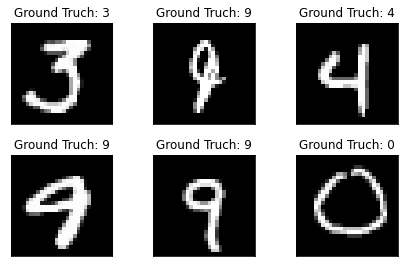

In [9]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title('Ground Truch: {}'.format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

# Model

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,10,kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        
        x = x.view(-1, 320)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
        

In [ ]:
# self.conv1 = nn.Conv2d(1,10,kernel_size=5)
# self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
# self.conv2_drop = nn.Dropout2d()
# self.fc1 = nn.Linear(320,50)
# self.fc2 = nn.Linear(50, 10)

In [ ]:
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum=momentum)

In [ ]:
print(network)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
    network.train()
    for batch_index, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx*len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item)
            train_counter.append(
                (batch_idx*64) + ((epoch - 1 ) * len(train_loader.dataset)))
            torch.save(network.state_dict(), './output/model.pth')
            torch.save(optimizer.state_dict(), './output/optimizer.pth')

In [ ]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Acc: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100.* correct / len(test_loader.dataset)))            

In [ ]:
%%time
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
test()